# Lab 4 - Codes for Efficient Transmission of Data

*This lab has been iteratively developed for EE 126 at UC Berkeley by Kangwook Lee, Kabir Chandrasekher, Max Kanwal, Tony Duan, David Marn, Ashvin Nair, Tavor Baharav, Sinho Chewi, Andrew Liu, Kamil Nar, David Wang, and Kannan Ramchandran.*

In this week's lab, you will explore implementing your own code for transmission of data!  

To see why efficient coding techniques are important, consider an erasure channel in which each packet sent gets dropped with some probability $p$.  If we wanted to convey a message, we could consider a feedback channel in which the receiver tells the sender which messages were received and the sender re-sends the dropped packets.  This process can be repeated until the receiver gets all of the intended message.  While this procedure is indeed optimal in all senses of the word, feedback is simply not possible in many circumstances.  What can we do in this situation?

In this lab, we will be looking at a specific type of code that will apply your knowledge of random bipartite graphs (the balls and bins model).

## Introduction 

The coding scheme we will work with in this lab will be a type of erasure code.  Under the binary erasure channel (BEC) model, bits that are sent through a noisy channel either make it through unmodified or are tagged as "corrupt", in which case the recieved information is dropped in all further information processing steps. In this lab, rather than transmitting bits, we will be transmitting packets, each of which will be dropped independently with probability $p$. 
<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Binary_erasure_channel.svg/156px-Binary_erasure_channel.svg.png"></center>
A code is considered optimal generally when all $n$ source symbols that need transmitting can be recovered from *any* $n$ encoded symbols.  Think of it this way: 
You want to stream the new season of House of Cards from Netflix at midnight.  But so do 1 million other people!  Obviously the server loads are going to be high, so how can Netflix ensure that everyone watches without intermittent lags (which are frustrating and will lose them customers)?  Well, one way is to increase the number of servers so that the load on any one server is decreased, but this costs a lot of money.  Another important thing for them to consider is in the transmission process.  When users are downloading the movie, Netflix servers don't want to have too much overhead to figure out which users need which bits of the video to get smooth playback.  If they use near-optimal codes to encode and constantly send out the same random chunks of the video's data to all users, then they can be sure that users get what they need in only a little more than $n$ transmissions *no matter what parts of the show each individual user lost through their specific channel*!

So what's the secret to this magic?  It's a two step process of clever encoding and decoding:

### Example: Encoding

Before jumping into the algorithm, let's look at an example. Suppose we are trying to transmit 4 packets of equal length: $x_1, x_2, x_3, x_4$. Rather than sending the individual packets, we will first use an encoding process, where we will XOR packets together before transmitting them. These XOR'd packets are the actual packets we will transmit, and we will refer to these combined packets as $y_i$'s, where $y_i$ is the $i$-th transmitted packet. The number of packets $d$ we choose to XOR together is chosen according to a **degree distribution**. Suppose we are working with the following degree distribution: $d$ is chosen uniformly between 1, 2, and 3 (so each of 1, 2, and 3 are selected with $\frac{1}{3}$ probability).

1) We'll create our first combined packet to transmit, $y_1$. We choose a degree $d$ at random between 1, 2, and 3. Let's say we get $d=2$. Now, we choose 2 packets at random out of our 4 original packets to XOR together. Let's say we get $x_1$ and $x_3$. Therefore, our packet we have $y_1 = x_1 \oplus x_3$.

2) Now, we'll create our second packet $y_2$. This time, we get $d=1$, and when we select one random packet from our original packets, we get $x_2$, so we have $y_2 = x_2$.

3) Let's say we continue this process and get the following packets: $y_3 = x_1 \oplus x_2 \oplus x_4$, $y_4 = x_3 \oplus x_4$, and $y_5 = x_3$.

We can visualize this encoding process as a random bipartite graph. Consider the following image for this example. We have all of the original packets, the $x_i$'s, on the left side, and the XOR'd packets to be transmitted, the $y_i$'s, on the right side. In the graph, there is an edge between $x_i$ and $y_j$ if $x_i$ is a part of packet $y_j$.

<img src="images/encoding_example.png" height="300" width="300">

### Example: Decoding

Now that we have encoded our packets, let's walk through the decoding process. In the lab, each of our transmitted packets is dropped with probability $p$, but in this example, we'll have $p=0$ (so no packets are dropped). In addition, we'll send the packet indices that make up a packet $y_i$, so the receiver knows which packets are being combined. We'll examine the situation from the perspective of the receiver. The receiver will keep track of which original packets, the $x_i$'s, it has figured out, and it will also keep track of packets that need to be processed further. Run the following code cell to walk through the interactive simulation!

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.html.widgets import *

%matplotlib inline  

IMAGE_NAME = "images/example_step{0}.jpg"

def example(t):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(mpimg.imread(IMAGE_NAME.format(t)))

interact(example, t=(1, 15, 1))


Here are some more formal descriptions of the encoding and decoding algorithms. Feel free to skip these if you fully understood the example above.

### Encoding Algorithm
1. For $n$ packets you want to transmit in total ($x_1$, $x_2$, ... $x_n$), pick $d$ according to some degree distribution such that $1\leq d \leq n$.
2. With $d$ picked, now select $d$ random packets of the $n$ and combine the bits together using the XOR operator.
3. Transmit this combined packet, along with the metadata telling which actual packet indices were XOR'd. Note that transmitting this extra information won't incur a lot of overhead if the size of metadata is relatively small compared to the rest of the packet.

### Decoding Algorithm
1. Reconstruct the list of packet indices which were XOR'd (in our case, these are just explicitly sent with the data).
2. For each source packet, check if the packet is a singleton, in which case the encoded packet is exactly equal to the actual packet.  If not, we can check if any of the packets that have been XOR'd are already known, in which case XOR that packet with the encoded packet and remove it from the list of packet indices that make up the encoded chunk.
3. After removing the packets, if there are two or more indices in the list for the encoded packet, we cannot figure out any more information!  Put it on the side for looking at later.
4. With any newly decoded information, we may be able to decode previously undecodable packets that we had put on the side.  Go through all unsolved packets and try to decode more packets until nothing more can be done.
5. Wait for the next encoded packet to come and repeat!

In this lab, you'll implement the decoding algorithm, and you'll also experiment with the parameter $d$, the number of packets to combine together, by trying out several different degree distributions.

## <font color = blue> $\mathcal{Q}$uestion 1. Code

### <font color = blue> We've provided you with some starter code, including a Packet class, a Transmitter class, a Channel class, and a Receiver class. Your job is to complete the `receive_packet()` function in the Receiver class. Feel free to write any additional functions that you may need.

### 1) Packet Class & Utility functions

A packet consists of...

#### ['chunk_indices', 'data' ]

##### chunk_indices: Which packets are chosen

##### data: The 'XOR'ed data

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import json
import random

class Packet:
    size_of_packet = 256
    def __init__(self, chunks, chunk_indices):
        self.data = self.xor(chunks)
        self.chunk_indices = chunk_indices

    def xor(self, chunks):
        tmp = np.zeros(Packet.size_of_packet, 'uint8')
        for each_chunk in chunks:
            tmp = np.bitwise_xor(tmp, each_chunk)
        return tmp
            
    def __len__(self):
        return len(self.chunk_indices)

### 2) Transmitter & Encoder Class

You can initiate an encoder with a string! Then, <tt>generate_packet()</tt> will return a randomly encoded packet.

In [2]:
from __future__ import division
from scipy import stats

def rho(d, K):
    if d == 0:
        return 0
    elif d == 1:
        return 1/K
    else: 
        return 1/(d * (d-1))
    
def tau(d, K, c, delta):
    S = c * np.log(K/delta) * np.sqrt(K)
    if d == 0:
        return 0
    elif d == K/S:
        return (S/K) * np.log(S/delta)
    elif d > K/S:
        return 0
    else:
        return (S/K) * (1/d)
    
def robust_dist(num_chunks, c=0.33, delta=0.39):
    z = sum([rho(d,num_chunks) + tau(d, num_chunks, c, delta) \
                for d in xrange(num_chunks)])
    xk = np.arange(num_chunks)
    pk = [(rho(d, num_chunks) + tau(d, num_chunks, c, delta))/z \
            for d in xrange(num_chunks)] 
    return stats.rv_discrete(name='robust', values=(xk,pk))

class Transmitter:
    def __init__(self, chunks, channel, degree_distribution, c=0.33, delta=0.39):
        self.chunks = chunks
        self.num_chunks = len(chunks)
        self.channel = channel
        self.degree_distribution = degree_distribution
        self.robust = robust_dist(self.num_chunks, c, delta)
        self.counter = c
        
    def generate_new_packet(self):
        if self.degree_distribution == 'single':
            #Always give a degree of 1
            n_of_chunks = 1
        elif self.degree_distribution == 'double':
            #Always give a degree of 2
            n_of_chunks = 2
        elif self.degree_distribution == 'baseline':
            """
            Randomly assign a degree from between 1 and 5.
            If num_chunks < 5, randomly assign a degree from 
            between 1 and num_chunks
            """
            n_of_chunks = random.randint(1,min(5, self.num_chunks))
        elif self.degree_distribution == 'sd':
            #Soliton distribution
            tmp = random.random()
            n_of_chunks = -1
            for i in range(2, self.num_chunks + 1):
                if tmp > 1/np.double(i):
                    n_of_chunks = int(np.ceil(1/tmp))
                    break
            if n_of_chunks == -1:
                n_of_chunks = 1
        elif self.degree_distribution == 'robust_sd':
            #Robust soliton
            n_of_chunks = self.robust.rvs(size=1)[0]    
        chunk_indices = random.sample(range(self.num_chunks), n_of_chunks)
        chunks = [ self.chunks[x] for x in chunk_indices ]
        return Packet( chunks, chunk_indices )
        
    def transmit_one_packet(self):
        packet = self.generate_new_packet()
        self.channel.enqueue( packet )

### 3) Channel Class

Channel class takes a packet and erase it with probability $p$.

In [3]:
class Channel:
    def __init__(self, p):
        self.p = p
        self.current_packet = None
        
    def enqueue(self, packet):
        if random.random() < self.p:
            self.current_packet = None
        else:
            self.current_packet = packet
            
    def dequeue(self):
        return self.current_packet

### 4) Receiver & Decoder Class

You can initiate a decoder with the total number of chunks. Then, <tt>add_packet()</tt> will add a received packet to the decoder.

In [4]:
class Receiver:
    def __init__(self, num_chunks, channel):
        self.num_chunks = num_chunks
        
        # List of packets to process.
        self.received_packets = []
        
        # List of decoded packets, where self.chunks[i] is the original packet x_i.
        self.chunks = []
        for i in range(self.num_chunks):
            self.chunks.append(  np.zeros(Packet.size_of_packet, 'uint8') )
            
        # Boolean array to keep track of which packets have been found, where self.found[i] indicates
        # if x_i has been found.
        self.found = [ False for x in range(self.num_chunks) ]
        self.channel = channel
        
    def receive_packet(self):
        packet = self.channel.dequeue()
        if packet is not None:
            ### SOLUTION ###
            # Peel off known packets first
            for idx in packet.chunk_indices[:]:
                if self.found[idx]:
                    packet.chunk_indices.remove(idx)
                    packet.data = np.bitwise_xor(packet.data, self.chunks[idx])
            
            # If only a singleton is left, record it.
            if len(packet) == 1:
                packet_idx = packet.chunk_indices[0]
                self.found[packet_idx] = True
                self.chunks[packet_idx] = packet.data
            # If the packet is still made up of more than one packet, store it.
            elif len(packet) > 1:
                self.received_packets.append(packet)
                return
            else:
                return
            
            terminate = False
            if not terminate:
                terminate = True
                for pkt in self.received_packets[:]:
                    for idx in packet.chunk_indices[:]:
                        if self.found[idx]:
                            packet.chunk_indices.remove(idx)
                            packet.data = np.bitwise_xor(packet.data, self.chunks[idx])
                    # Check if this packet is a singleton. If it is, we need to go through received_packets again.
                    if len(pkt) == 1:
                        packet_idx = packet.chunk_indices[0]
                        self.found[packet_idx] = True
                        self.chunks[packet_idx] = packet.data
                        terminate = False
                        self.received_packets.remove(pkt)
                    elif len(packet) == 0:
                        self.received_packets.remove(pkt)
             
    def isDone(self):
        return self.chunksDone() == self.num_chunks

    def chunksDone(self):
        return sum(self.found)

## <font color = blue> $\mathcal{Q}$uestion 2. Sending the Image
### <font color = blue> a. Break up the image shown below into $1024$ packets of size $256$ each.

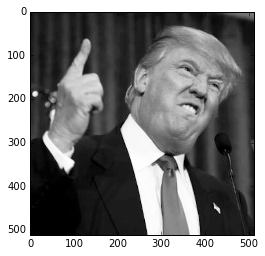

In [5]:
from scipy import misc
import matplotlib.cm as cm
from PIL import Image
import numpy as np

l = np.asarray(plt.imread("images/image.jpg"))
#converts the image to grayscale
x = np.zeros((512,512))
for i in xrange(512):
    for j in xrange(512):
        x[i][j] = l[i][j][0]*0.299+l[i][j][1]*0.587+l[i][j][2]*0.113 
x = x.astype('uint8')

plt.imshow(x, cmap = cm.Greys_r)

In [6]:
tt= x.reshape(1, 512*512)[0]
size_of_packet = 256 
num_of_packets = 1024
assert len(tt) == size_of_packet * num_of_packets

# Chunks is a list of the 1024 packets. Break up the image, and store the packets in this list!
chunks = [ [] for _ in range(num_of_packets) ]

# SOLUTION
for i in range(num_of_packets):
    chunks[i] = np.array( tt[ i*size_of_packet : (i+1)*size_of_packet ], 'uint8')

### <font color = blue> b. Using the 'single' degree distribution defined in the Transmitter class, send the image over a channel with erasure probability 0.2.  How many packets did you need to send? Display the data you receive every $100$ packets in addition to the data you receive at the end.

### <font color = blue>i. Plot the number of packets decoded as a function of the number of packets you receive. (The current_sent array should be helpful here)

You may find the following function useful:

In [7]:
def visualize( chunks ):
    plt.imshow(chunks, cmap = cm.Greys_r)

The number of packets received: 9572


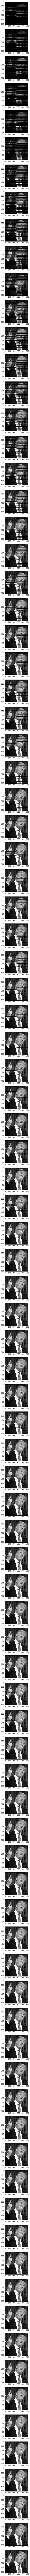

In [8]:
p = 0.2
ch = Channel(p)
tx = Transmitter( chunks, ch, 'single' )
rx = Receiver( len(chunks), ch )

ct = 0
intermediate_data = []
current_sent = []
while not rx.isDone():
    tx.transmit_one_packet()
    rx.receive_packet()
    ct += 1
    if ct % 100 == 0:   
        intermediate_data.append( np.array(rx.chunks, 'uint8').reshape(512,512) )
        current_sent.append(sum(rx.found))

received_data = np.array(rx.chunks, 'uint8').reshape(512,512)
print "The number of packets received: {}".format(ct)

### Incrementally show the data received
n_of_figures = int(ct/100)
fig = plt.figure( figsize=(8, 3*n_of_figures) )

for i in range(n_of_figures-1):
    fig.add_subplot(n_of_figures,1,i+1)
    visualize(intermediate_data[i])

fig.add_subplot(n_of_figures,1,n_of_figures)
visualize(received_data)

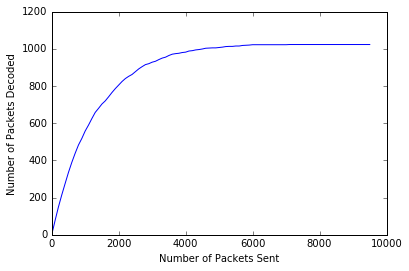

In [9]:
# SOLUTION
plt.plot(np.arange(len(current_sent) + 1) * 100, [0] + current_sent)
plt.xlabel("Number of Packets Sent")
plt.ylabel("Number of Packets Decoded")
plt.show()

### <font color = blue> b ii. Looking at the graph, we see that it gets harder and harder to find the rest as we decode more and more chunks. Does this remind you of a well known theoretical problem?
Hint: Try out some small examples!

#### Solution: This is the coupon collector problem (here's the Wikipedia article for it: https://en.wikipedia.org/wiki/Coupon_collector's_problem). Since this problem was only briefly mentioned in class, no need to deduct points from your self-grade if you didn't know it.

### <font color = blue> c. Using the 'double' degree distribution defined in the Transmitter class, send the image over a channel with erasure probability 0.2.  What happens?

In [ ]:
p = 0.2
ch = Channel(p)
tx = Transmitter( chunks, ch, 'double' )
rx = Receiver( len(chunks), ch )

ct = 0
while not rx.isDone():
    tx.transmit_one_packet()
    rx.receive_packet()
    ct += 1

received_data = np.array(rx.chunks, 'uint8').reshape(512,512)
print "The number of packets received: {}".format(ct)

### <font color=red> c. (Solution)
<img src="http://i.imgur.com/7DrMutD.png" style="width: 100px; height: 100px;">
Your notebooks should have frozen. The receiver can only begin decoding when it sees a singleton, so if we only send doubletons, the decoding process can never begin.

## <font color = blue> $\mathcal{Q}$uestion 3. Randomized Distributions

### <font color = blue> a.  You have seen two degree distributions so far.  Both of these have been deterministic, and one worked better than the other.  Using the 'baseline' degree distribution, send the image over a channel with erasure probability 0.2.  Plot the number of packets decoded against the number of packets transmitted.

In [10]:
p = 0.2
num_trials = 1
ch = Channel(p)
tx_baseline = Transmitter( chunks, ch, 'baseline' )
baseline_packets = []

for _ in xrange(num_trials):
    rx = Receiver( len(chunks), ch )
    ct = 0
    while not rx.isDone():
        tx_baseline.transmit_one_packet()
        rx.receive_packet()
        ct += 1
        if ct % 100 == 0:   
            baseline_packets.append(sum(rx.found))
    baseline_packets.append(ct)
    
print "The number of packets received: {}".format(ct)

The number of packets received: 5965


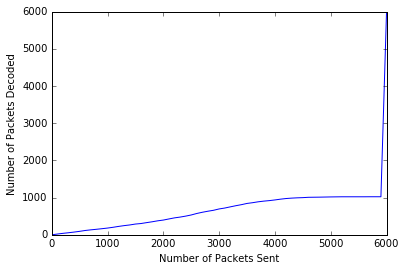

In [11]:
# SOLUTION
plt.plot(np.arange(len(baseline_packets) + 1) * 100, [0] + baseline_packets)
plt.xlabel("Number of Packets Sent")
plt.ylabel("Number of Packets Decoded")
plt.show()

### <font color = blue> b.  Let's examine one final degree distribution. Using the 'sd' degree distribution, send the image over a channel with erasure probability 0.2.  Plot the number of packets decoded against the number of packets transmitted.

In [12]:
p = 0.2
num_trials = 1
ch = Channel(p)
tx_sd = Transmitter( chunks, ch, 'sd' )
current_sd = []

for _ in xrange(num_trials):
    rx = Receiver( len(chunks), ch )
    ct = 0
    while not rx.isDone():
        tx_sd.transmit_one_packet()
        rx.receive_packet()
        ct += 1
        if ct % 100 == 0:   
            current_sd.append(sum(rx.found))
    current_sd.append(ct)
    
print "The number of packets received: {}".format(ct)

The number of packets received: 13451


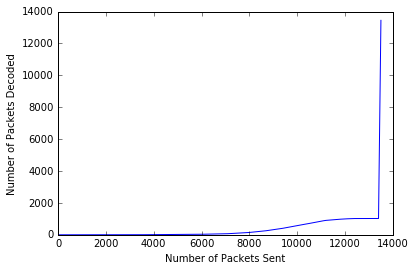

In [13]:
# SOLUTION
plt.plot(np.arange(len(current_sd) + 1) * 100, [0] + current_sd)
plt.xlabel("Number of Packets Sent")
plt.ylabel("Number of Packets Decoded")
plt.show()

The codes we asked you to look at and create are known generally as *fountain codes*. In the last part, we implemented a degree distribution called the soliton distribution, which is defined as follows.

$$
 \rho(d) =
  \begin{cases} 
      \hfill \frac{1}{K}    \hfill & \text{ if $d = 1$} \\
      \hfill \frac{1}{d(d-1)} \hfill & \text{ if $d = 2,3,...,K$} \\
  \end{cases}
$$

It turns out that this distribution, which was discovered and named by the creator of LT Codes, Michael Luby, is ideal in expectation. Unfortunately in practice, it fares much more poorly because there are relatively few packets of lower degree. Because of this, the receiver typically stores many higher degree packets, and when a singleton is received, many packets are able to be decoded. If you are interested, see if you can come up with a better distribution! 

## Some Final Comments

We mentioned above that the soliton distribution is ideal in expectation, but doesn't perform very well, as we saw above. The robust soliton distribution performs much better and is defined as follows.

Robust Soliton:  $\mu(d) = \frac{\rho(d) + \tau(d)}{\sum_{k}\rho(k) + \tau(k)}$

where
$$
 \tau(d) =
  \begin{cases} 
      \hfill \frac{S}{K} \cdot \frac{1}{d}    \hfill & \text{ if $d < K/S$} \\
      \hfill \frac{S}{K}\ln{(\frac{S}{\delta})} \hfill & \text{ if $d = K$} \\
      \hfill 0 \hfill & \text{ if $d > K/S$} \\
  \end{cases}
$$
and $S= c\ln{(\frac{K}{\delta})}\sqrt{K}$. Note that $c$ and $\delta$ are parameters that we can tune. Below, we try transmitting our 1024 packets over a channel with erasure probability $p = 0.2$ and see how many packets we need. For more information on this, please see [1].

In [14]:
p = 0.2
num_trials = 1
ch = Channel(p)
tx_rsd = Transmitter( chunks, ch, 'robust_sd' )
current_rsd = []

for _ in xrange(num_trials):
    rx = Receiver( len(chunks), ch )
    ct = 0
    while not rx.isDone():
        tx_rsd.transmit_one_packet()
        rx.receive_packet()
        ct += 1
        if ct % 100 == 0:   
            current_rsd.append(sum(rx.found))
    current_rsd.append(ct)
    
print "The number of packets received: {}".format(ct)

The number of packets received: 6644


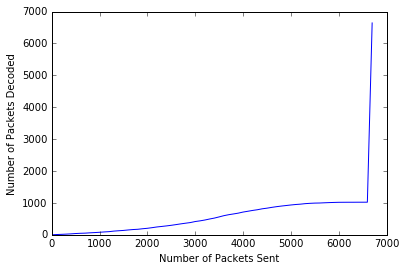

In [15]:
# SOLUTION
plt.plot(np.arange(len(current_rsd) + 1) * 100, [0] + current_rsd)
plt.xlabel("Number of Packets Sent")
plt.ylabel("Number of Packets Decoded")
plt.show()

## References
[1] D. Mackay.  Information Theory, Inference, and Learning Algorithms. 2003

## <font color = blue> $\mathcal{C}$ompetition (Optional)

For this week's lab competition, we consider the following problem. We have $n$ total colors, $d$ balls for each color, and a total of $M$ bins. Out of the $n$ colors*, only $K$ colors are 'active.' We will play a game in which we will throw our $Kd$ balls of 'active' colors into the $M$ bins and try to recover all of the 'active' colors according to the following rules of the game:

1. For a particular 'active' color, each of the $d$ balls for that color must go to different bins.  
2. If a bin contains only one ball, then all of the other $d-1$ balls of that 'active' color can be removed from their respective bins.  
3. We continue this process until all of the balls have been removed from the bins, or there are no more bins that contain only one ball.

<img src="images/ball_coloring.png" height="400" width="400">

\* You may be wondering about the significance of the parameter $n$. If we know the exact value of $K$, then we can come up with a strategy that will always recover all $K$ colors. Therefore, $K$ is random, and it depends on the total number of colors $n$.

### Example

Let's look at an example of this game. Consider the case where we have $K=3$ 'active' colors, $d=3$ balls of each 'active' color, and $M=5$ bins. Suppose that we throw our $Kd=9$ total balls randomly into the 5 bins according to the following diagram. The nodes on the left side represent the balls, while the nodes on the right side correspond to the bins.

<img src="images/coloring_example.png" height="600" width="600">

Now, we'll follow the rules of the game to try to discover the 'active' colors using what we see in the bins. As in the case above when we were transmitting packets, we assume that the bins know which color indices comprise the bin, and here, we'll think of the data as the colors themselves. We begin in the left diagram, and our first step is to find bins that only contain one ball. Indeed, we see that bin 4 contains a single yellow ball, so we know that this is one of our 'active' colors. After this discovery, we can then remove all yellow balls from their respective bins, and the right diagram shows the updated colors in the bins. we see that bin 2 contains only one blue ball, and bin 3 only contains one red ball. Therefore, we've discovered two more 'active' colors, and after removing all blue and red balls, there are no more balls left in the bins, so we have successfully found all of the 'active' colors!

### Competition Details

In our example above, we were able to recover all of our 'active' colors, but we're interested in the following questions: Would we have been able to do so with a smaller number of bins? What if we changed our strategy of determining which balls to throw to which bins? Your job is to find a way to distribute your $Kd$ balls into the bins and determine a ratio $\frac{M}{K}$ that determines how many bins you need per 'active' color. In the competition, you will try to find a strategy that minimizes your ratio $\frac{M}{K}$ while maintaining at least a 95% probability of being able to discover all $K$ 'active' colors.

The following code simulates the ball coloring problem, and below it, the `strategy()` function is used to describe where you throw the balls of each 'active' color. Right now, the default strategy simply throws the balls randomly into the bins.

In [ ]:
# n is the number of total colors
# K is the number of active colors
# ratio is M/K (what you are trying to minimize!)
# d is number of balls per color
# num_trials is number of simulations to run
def simulate_ball_coloring(n, K, ratio, d, num_trials):
    num_successes = 0.0
    for i in range(num_trials):
        # Total number of bins to use
        M = int(K * ratio)
        
        colors = np.arange(1, n + 1)
        active_colors = np.random.choice(colors, K, replace=False)
        dist = strategy(active_colors, d, ratio)
        
        # Keeps track of number of balls in each bin.
        count = np.zeros(M)
        # Keeps track of sum of colors in each bin.
        colors = np.zeros(M)
        
        for color in dist:
            bins = dist[color]
            count += bins
            colors += color * bins
        
        done = False
        
        while not done:
            done = True
            singletons = np.where(count == 1)
            if len(singletons[0]) > 0:
                done = False
                for singleton in singletons[0]:
                    color = colors[singleton]
                    if color > 0:
                        count -= dist[color]
                        colors -= color * dist[color]
            
        if np.sum(count) == 0:
            num_successes += 1
        
    print "Probability of Success:", num_successes / num_trials

# K is a list of indices of 'active' colors, d is the number of balls for each color, ratio is M/K.
# You should return a dictionary, where the keys are the indices of the 'active' colors, and the values are
# M-dimensional numpy arrays of 0's and 1's, with the 1's indicating the bins that contain balls of this color.
# Here, the default strategy just picks the bins uniformly at random.
def strategy(active_colors, d, ratio):
    M = int(len(active_colors) * ratio)
    dist = {}
    for color in active_colors:
        bins = np.random.choice(np.arange(M), d, replace=False)
        color_dist = np.zeros(M)
        color_dist[bins] = 1
        dist[color] = color_dist
    return dist

simulate_ball_coloring(1000, 500, 1.000, 12, 100)

### Concrete Specifications

In the competition, you are trying to develop a distribution strategy for the balls of active colors to minimize the ratio $\frac{M}{K}$ needed to achieve a success probability of at least 95%. We're going to examine the problem where $n = 1000$, and $d=12$. The top three teams with the lowest $\frac{M}{K}$ ratios will receive extra credit! You may work on teams of 2 to 3 students, and turn in the separate Python2 file, strategy.py, with the ratio you achieved as well as your strategy function. Note that if we are unable to run your code, you will be disqualified from the competition. In addition, turn a text file, strategy.txt, which lists your team members and describes your final strategy. Good luck! 